In [12]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [13]:
from helpers import load_data

# load dataset
x, y = load_data()

In [14]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [15]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""

    # get k'th subgroup in test, others in train: TODO
    test_ind = k_indices[k]
    train_ind = k_indices[np.arange(len(k_indices)) != k].ravel()
    
    x_tr, y_tr = x[train_ind], y[train_ind]
    x_te, y_te = x[test_ind], y[test_ind]

    # form data with polynomial degree: TODO
    x_tr = build_poly(x_tr, degree)
    x_te = build_poly(x_te, degree)

    # ridge regression: TODO
    loss_tr, w = ridge_regression(y_tr, x_tr, lambda_)

    # calculate the loss for train and test data: TODO
    loss_te = compute_mse(y_te, x_te, w)

    return w, loss_tr, loss_te

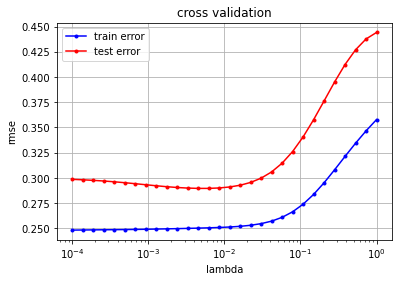

In [16]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr_arr = np.zeros((len(lambdas), k_fold))
    rmse_te_arr = np.zeros((len(lambdas), k_fold))
    w_list = []

    # cross validation: TODO
    for i_lambda, lambda_ in enumerate(lambdas):
        for k in range(len(k_indices)):
            w, mse_tr, mse_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            
            rmse_tr_arr[i_lambda, k] = np.sqrt(2*mse_tr)
            rmse_te_arr[i_lambda, k] = np.sqrt(2*mse_te)
            w_list.append(w)
    
    rmse_tr = np.mean(rmse_tr_arr, axis=1)
    rmse_te = np.mean(rmse_te_arr, axis=1)  
#     print(rmse_tr, '\n', '\n', rmse_te)
          
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    
    return np.array(w_list), rmse_tr_arr, rmse_te_arr

w_array, rmse_tr_arr, rmse_te_arr = cross_validation_demo()
# cross_validation_demo()

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

In [17]:
mean_rmse = np.mean(rmse_te_arr, axis=1)
std_rmse = np.std(rmse_te_arr, axis=1)
risk = mean_rmse + 2*std_rmse
# len(w_list)
# 18//4
w_arr_re = w_array.reshape(30, 4, 8)
new_w =np.mean(w_arr_re, axis=1)
new_w.shape
new_w[0]

array([ 0.1921568 ,  0.31093239,  0.43078753, -0.20639696, -0.08399411,
        0.05214863, -0.00876129,  0.00049559])

In [18]:
def obtain_best_model(rmse_te_array, w_array, k_folds, degree):
    """obtain best model based on rmse and std with 95% confidence interval"""
    mean_rmse = np.mean(rmse_te_array, axis=1)
    std_rmse = np.std(rmse_te_array, axis=1)
    risk = mean_rmse + 2*std_rmse
    
    w_array = w_array.reshape(w_array.shape[0]/k_folds, k_folds, degree + 1)
    ind = np.argmin(risk) // k_fold
    
    return w_array[ind]

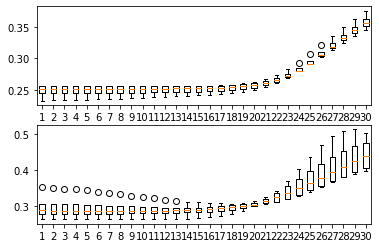

In [19]:
#Boxplots for the training and testing errors
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.boxplot(rmse_tr_arr.T)
ax2 = fig.add_subplot(212)
ax2.boxplot(rmse_te_arr.T)
plt.show()

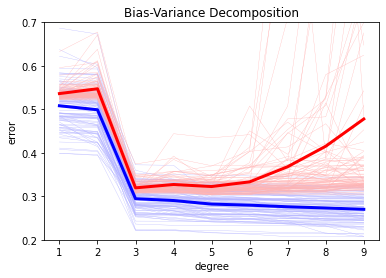

In [20]:
from costs import *
from ridge_regression import ridge_regression
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T

        # split data with a specific seed: TODO
        x_tr, y_tr, x_te, y_te = split_data(x, y, ratio_train, seed)

        # bias_variance_decomposition: TODO
        for index_deg, deg in enumerate(degrees):
            _x_tr = build_poly(x_tr, deg)
            _x_te = build_poly(x_te, deg)
            
            mse_tr, w = least_squares(y_tr, _x_tr)
            rmse_tr[index_seed, index_deg] = np.sqrt(2*mse_tr)
            rmse_te[index_seed, index_deg] = compute_rmse(y_te, _x_te, w)

    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)
    
    return rmse_tr, rmse_te

rmse_tr, rmse_te = bias_variance_demo()

In [ ]:
#When using ridge regression instead of least squares, this has the effect of 